# CoDAXS - Compositional Data Analysis from XRF Scanning

## Citation
Niederstätter, M., Ortler, M.-L., & Molenaar, A. (2024). CoDAXS - Compositional Data Analysis from XRF scanning (v0.1). Zenodo. https://doi.org/10.5281/zenodo.14001254


## Import all necessary packages

In [1]:
#import modules
import CoDAXS_modules as mo

#import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path, PureWindowsPath

## Define input and output paths

- Quality control should be done before importing the XRF data
- Define input directory containing your XRF-scan .csv file (comma separated and positive count data) with depth in the first column
- Define output directory, in which a folder with the core name will be created, where dataframes and figures will be saved
- Define the figure output format: pdf, svg, jpg or png
- When running the same core twice, old files will be overwritten!

In [5]:
#define input and output folders!
input_path = Path(r'C:\...........')
output_path = Path(r'C:\..........') # here a new folder will be created with the core name

#put the name of your .csv file
file_name = 'example_XRFCoreScan_counts.csv'

# Create a new folder inside output_path with the same name as file_name 
output_folder = output_path / file_name.replace('.csv', '')
output_folder.mkdir(parents=True, exist_ok=True)

#Figure output format
output_format = 'svg' #'pdf', 'svg' 'jpg' or 'png' are possible

#import data
raw_XRF = pd.read_csv((input_path / file_name), index_col = 0, delimiter=',')
raw_XRF.head()

,Si,K,Ca,Ti,Fe,Co,Ni,Sr,P
depth (mm),,,,,,,,,
0.0,820,6907,204289,4788,20336,275,342,557,21
0.5,629,5362,171038,4252,21630,383,276,622,37
1.0,719,6157,186168,5322,23585,359,431,587,6
1.5,943,7644,211356,5680,24734,418,306,494,110
2.0,980,8753,220955,6167,26555,350,344,559,60


## Select elements
Define the elements you want to use for this analysis

In [5]:
selected_elements = ['Si', 'K', 'Ca', 'Ti', 'Fe']
elements = raw_XRF[selected_elements]

## Data processing
- Determines the amount of zeros that were replaced. We do not perform a quality control here, which should be done before.
- Zero replacement by the half of each columns non-zero minimum (detection limit)
- Centred-log-ratio (clr) transformation (to overcome marix effects and downcore changes of physical properties)

In [6]:
#Zero replacement
elements = mo.zero_replacement(elements)
#Clr-transformation
elements_clr = mo.clr_transformation(elements)

#Optional: save the processed elements_clr dataframe as .csv
elements_clr.to_csv(Path(output_folder) / 'elements_clr.csv', index=True)

0 zeros were replaced in 'Si'
0 zeros were replaced in 'K'
0 zeros were replaced in 'Ca'
0 zeros were replaced in 'Ti'
0 zeros were replaced in 'Fe'


## Plot the clr transformed elements

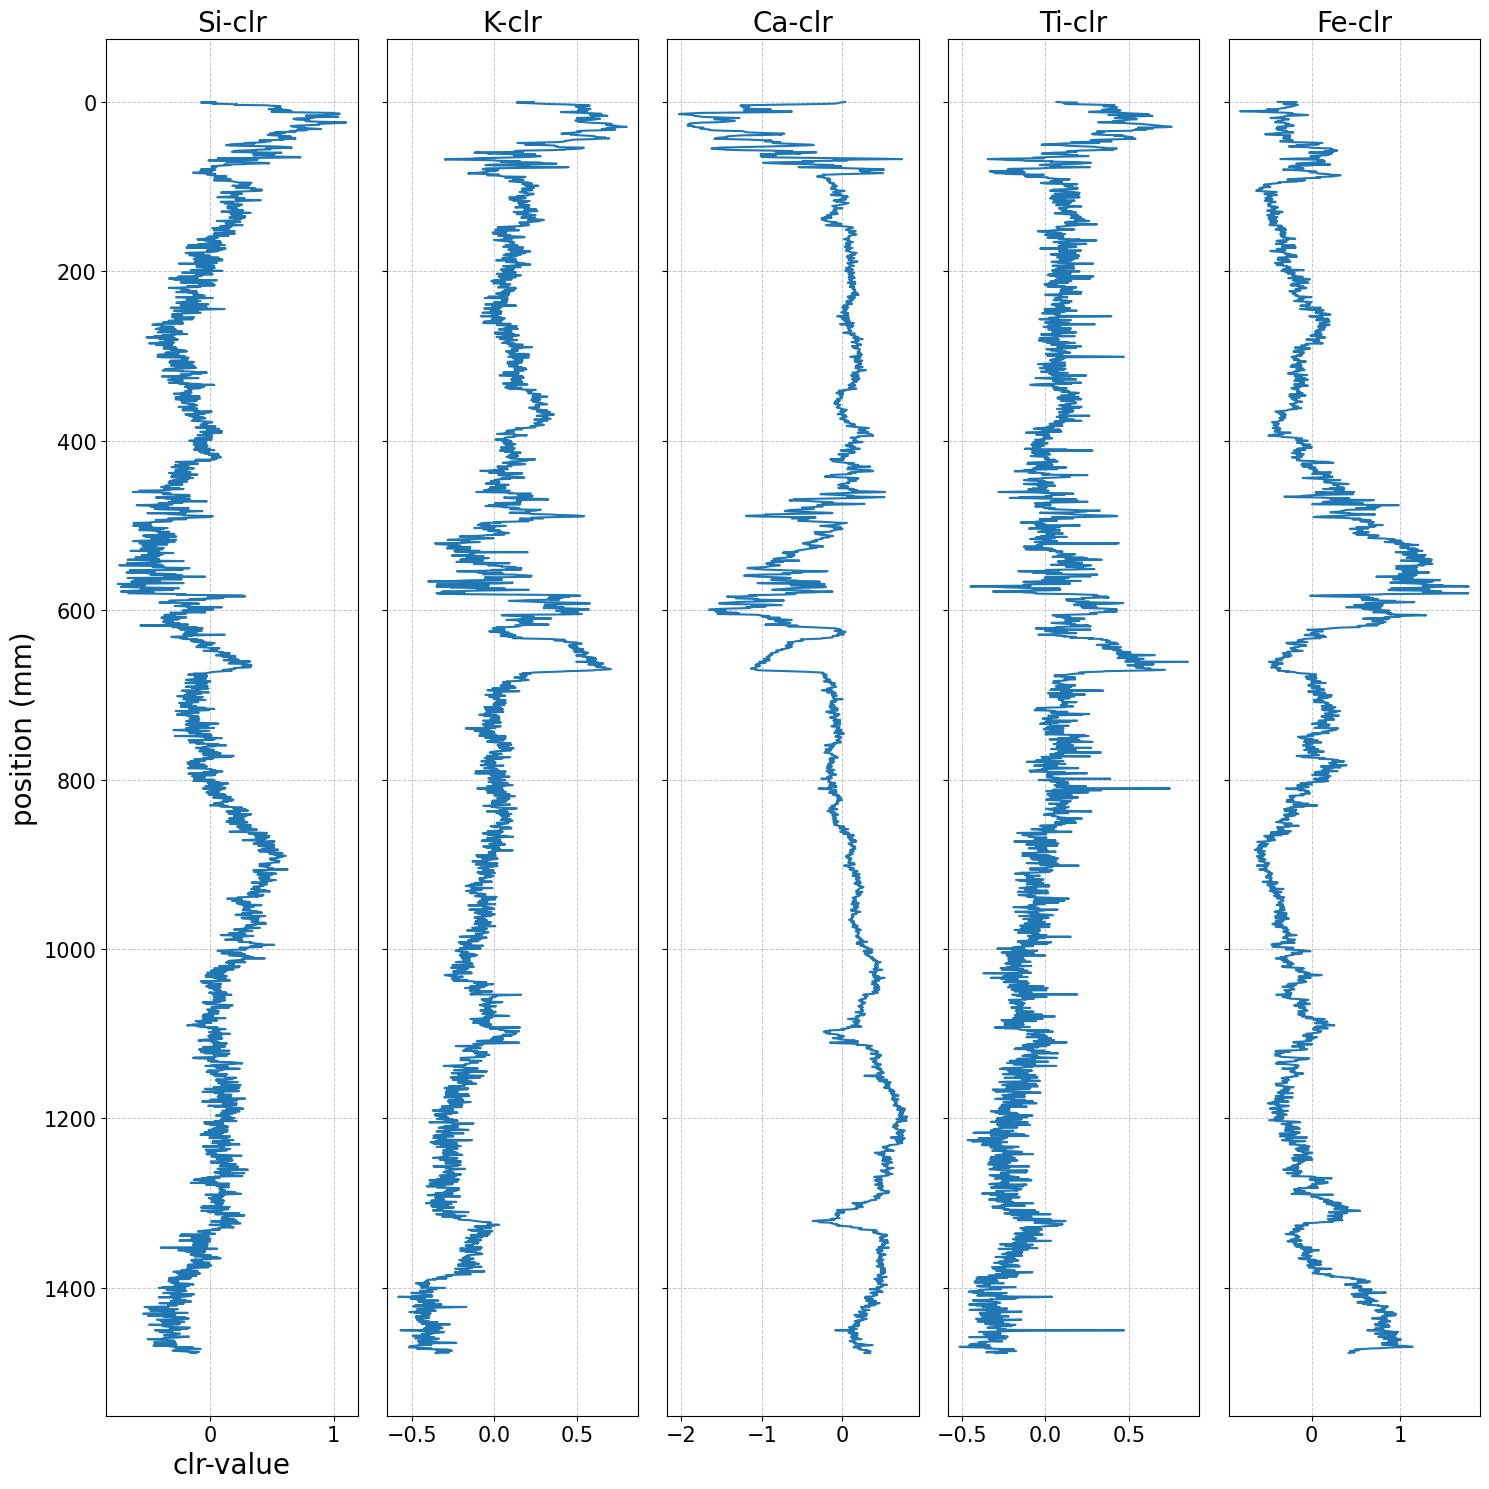

In [7]:
fig, ax = plt.subplots(1, len(elements_clr.columns), figsize=(15, 15)) #adjust figsize for your needs
y_label = elements_clr.index.name if elements_clr.index.name else 'Depth (xx)'

for i, column in enumerate(elements_clr.columns):
    ax[i].plot(elements_clr[column], elements_clr.index)
    ax[i].invert_yaxis()
    ax[i].set_title(f"{column}-clr", fontsize=20)
    
    if i == 0:
        ax[i].set_xlabel('clr-value', fontsize=20)
        ax[i].set_ylabel(y_label, fontsize=20)
    else:
        ax[i].tick_params(axis='y', labelleft=False, labelsize=15)

    ax[i].tick_params(axis='y', labelsize=15)
    ax[i].tick_params(axis='x', labelsize=15)
    ax[i].grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7) 

plt.tight_layout()
plt.savefig(f"{output_folder}/elements_clr_plot.{output_format}")
plt.show()

## Principal Component Analysis (PCA)
- Perform singular value decomposition (which is numerically more stable and allows further analysis of the data; see Greenacre et al., 2022)
- Calculate explained variance per PC, loadings and scores

In [8]:
explained_variance, loadings, scores = mo.svd(elements_clr)
#Save the dataframes if you want:
#explained_variance.to_csv(f"{output_folder}/explained_variance.csv")
#loadings.to_csv(f"{output_folder}/loadings.csv")
#scores.to_csv(f"{output_folder}/scores.csv")

## Explained Variance Plot
- shows how much variance is explained by each singular value or principal componente

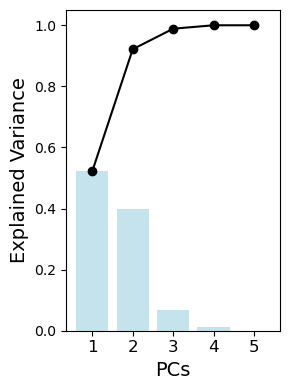

In [9]:
# Plotting the explained variance and cumulative explained variance 
fig, ax1 = plt.subplots(figsize=(3, 4))

# Bar plot for explained variance and Cumulative variance plot
ax1.bar(explained_variance.index, explained_variance['explained variance'], color="lightblue", alpha=0.7, label='Explained Variance')
ax1.plot(np.cumsum(explained_variance['explained variance']), '-o', color='k', label='Cumulative Explained Variance')

ax1.set_xlabel('PCs', fontsize=14)
ax1.set_ylabel('Explained Variance', fontsize=14)  # Shared y-axis label for both bar and line plot
#ax1.set_title('Explained and Cumulative Explained Variance', fontsize=13)
ax1.set_xticks(explained_variance.index)
ax1.set_xticklabels(explained_variance.index, fontsize=12)
plt.tight_layout()

plt.savefig(f"{output_folder}/explained_variance_plot.{output_format}")

plt.show()

## Loadings Biplots
- Visualizes how each element contributes to the principal components (PCs)
- The direction of the arrows indicates the type of correlation between the elements. Elements pointing in similar directions are positively correlated, while those in opposite directions are negatively correlated.

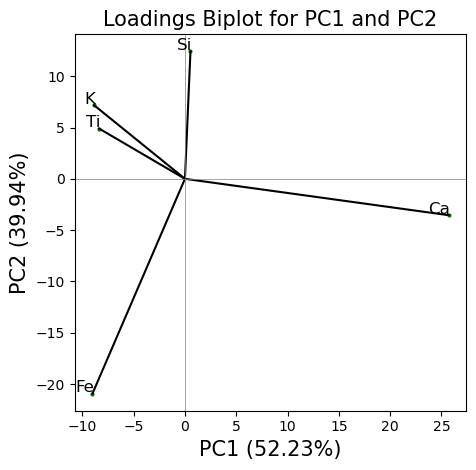

In [10]:
ax = loadings.plot(kind='scatter', x='PC1', y='PC2', s=4, color='Green')

for i, row in loadings.iterrows():
    ax.plot([0, row['PC1']], [0, row['PC2']], color='k')
    ax.annotate(i, (row['PC1'], row['PC2']), xytext=(1, 1), textcoords='offset points', ha='right', fontsize=12)
    
ax.set_aspect('equal') #should be equal for interpretation
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlabel(f'PC1 ({(explained_variance.loc["1", "explained variance"] * 100):.2f}%)', fontsize=15)
ax.set_ylabel(f'PC2 ({(explained_variance.loc["2", "explained variance"] * 100):.2f}%)', fontsize=15)
ax.set_title('Loadings Biplot for PC1 and PC2', fontsize=15)

plt.tight_layout()
plt.savefig(f"{output_folder}/loadings_PC1vsPC2.{output_format}")
plt.show()

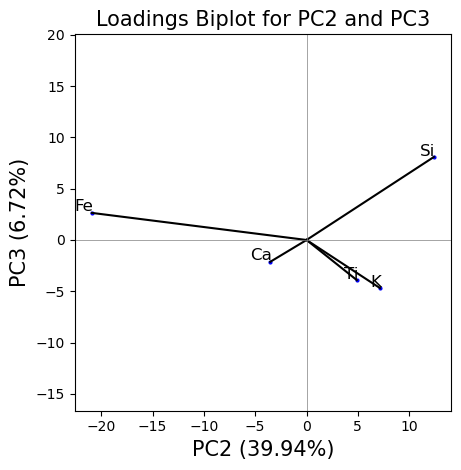

In [11]:
ax = loadings.plot(kind='scatter', x='PC2', y='PC3', s=4, color='Blue')
for i, row in loadings.iterrows():
    ax.plot([0, row['PC2']], [0, row['PC3']], color='k')
    ax.annotate(i, (row['PC2'], row['PC3']), xytext=(1, 1), textcoords='offset points', ha='right', fontsize=12)
ax.set_aspect('equal')
ax.axhline(0, color='gray', linewidth=0.5)
ax.axvline(0, color='gray', linewidth=0.5)
ax.set_xlabel(f'PC2 ({(explained_variance.loc["2", "explained variance"] * 100):.2f}%)', fontsize=15)
ax.set_ylabel(f'PC3 ({(explained_variance.loc["3", "explained variance"] * 100):.2f}%)', fontsize=15)
ax.set_title('Loadings Biplot for PC2 and PC3', fontsize=15)
x_limits, y_limits = ax.get_xlim(), ax.get_ylim()
max_range = max(abs(x_limits[1] - x_limits[0]), abs(y_limits[1] - y_limits[0]))
x_center, y_center = (x_limits[1] + x_limits[0]) / 2, (y_limits[1] + y_limits[0]) / 2
ax.set_xlim([x_center - max_range / 2, x_center + max_range / 2])
ax.set_ylim([y_center - max_range / 2, y_center + max_range / 2])

plt.tight_layout()
plt.savefig(f"{output_folder}/loadings_PC2vsPC3.{output_format}")
plt.show()

## Scores vs Depth plots
- Shows the downsection change of the PCs and how much variance they explain

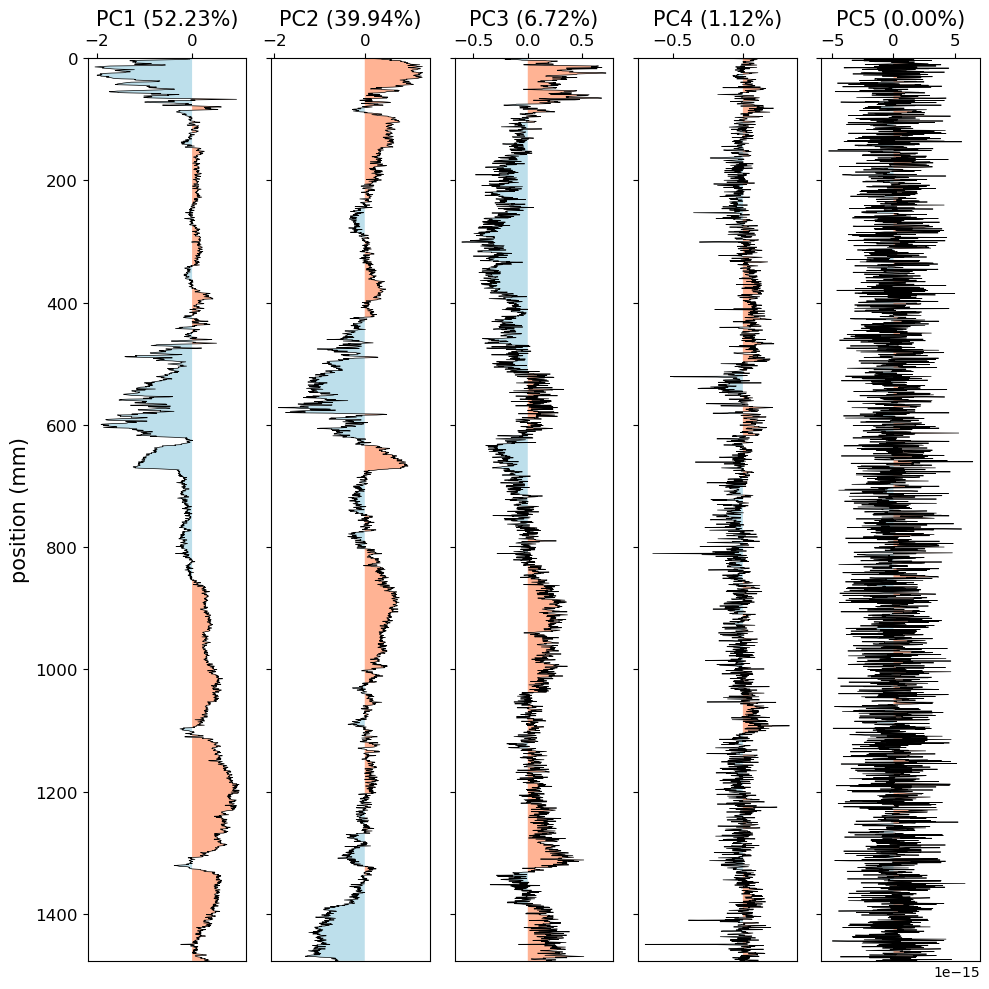

In [12]:
# Define the number of components to plot
n_components = 5  

fig, ax = plt.subplots(1, n_components, sharey=True, figsize=(10, 10))  # Change the figsize if needed
y_label = elements_clr.index.name if elements_clr.index.name else 'Depth (xx)'

for i, col in enumerate(scores.columns[:n_components]):
    pc_number = i + 1  # PC numbers are 1-based
    explained_var = explained_variance.loc[str(pc_number), "explained variance"] * 100
    ax[i].plot(scores[col], scores.index, c='black', linewidth=0.5)
    ax[i].fill_betweenx(scores.index, scores[col], where=scores[col] >= 0, color='lightsalmon', alpha=0.8, linewidth=0)
    ax[i].fill_betweenx(scores.index, scores[col], where=scores[col] < 0, color='lightblue', alpha=0.8, linewidth=0)
    ax[i].set_title(f'{col} ({explained_var:.2f}%)', fontsize=15)
    ax[i].set_ylim(max(scores.index), min(scores.index))
    ax[i].tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True, labelsize=12)
    ax[i].tick_params(axis='y', labelsize=12)

ax[0].set_ylabel(y_label, fontsize=15)
plt.savefig(f"{output_folder}/downcore_scores.{output_format}")
plt.tight_layout()
plt.show()

## Clustering of the PCA scores
- Clustering allows independently classify the PCA scores and identify intervals of similar geochemisty
- The clustering functions create plots and a dataframe, which contains the cluster label to which each datapoint is assigned.They can be saved in a separate folder. 
- To modify the plots the functions in the XRF_modules.py file can be adjusted.
- Here 2 algorithms are possible: Agglomerative Hierarchical or Kmeans. But there are many other possibilities, see: https://scikit-learn.org/1.5/modules/clustering.html


In [13]:
#Define these variables before clustering
n_clusters = 3 #defines the number of clusters
n_components = 3 #determines the number of components used for the clustering
linewidth = 1 #used for the 'synthetic' core on which the clusters are plotted, depends on scanning resolution

#color palette for the clusters. Define your own colors if you want: https://matplotlib.org/stable/users/explain/colors/colors.html
colors = ['#DAA520', '#9E0142', '#F46D43', '#3288BD', '#66C2A5', '#FEE08B', '#5E4FA2', '#ABDDA4', '#3288BD', '#FDAE61']

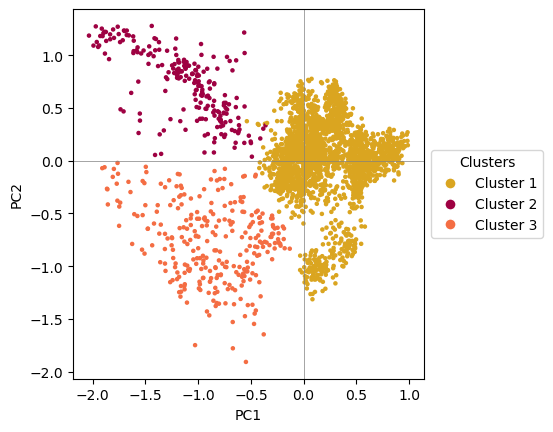

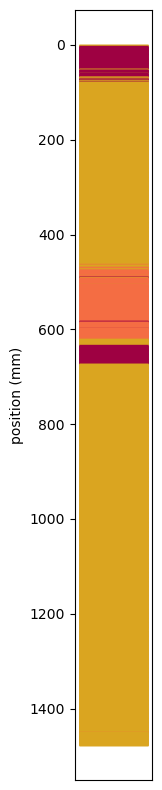

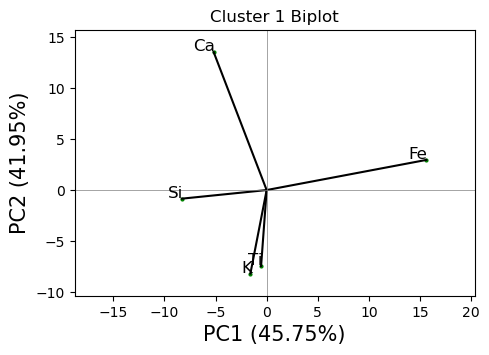

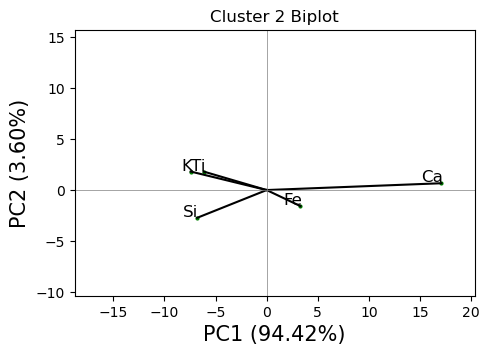

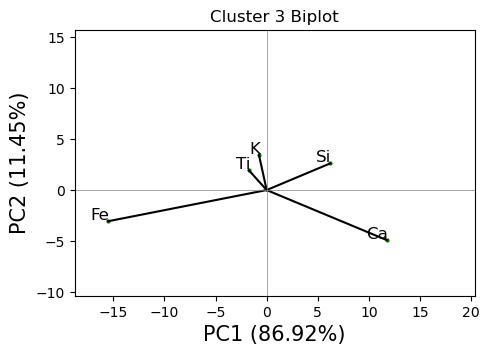

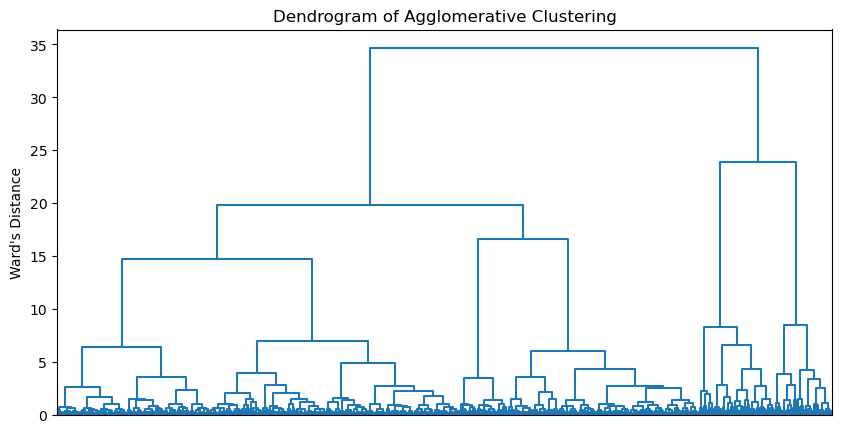

,cluster
position (mm),
0.0,0
0.5,0
1.0,0
1.5,0
2.0,0
...,...
1475.0,0
1475.5,0
1476.0,0


In [14]:
#If savefig is True, a new folder in your output folder will be created

#Agglomerative hierarchical clustering
mo.agglomerative_clustering(scores, 
                            elements_clr, 
                            n_clusters, 
                            colors, 
                            output_folder = output_folder,
                            output_format = output_format,
                            savefig=True, #Do you want the save the plots and cluster dataframe? 
                            linewidth = linewidth) #if you want to adjust the plots further, go to the functions in XRF_modules.py


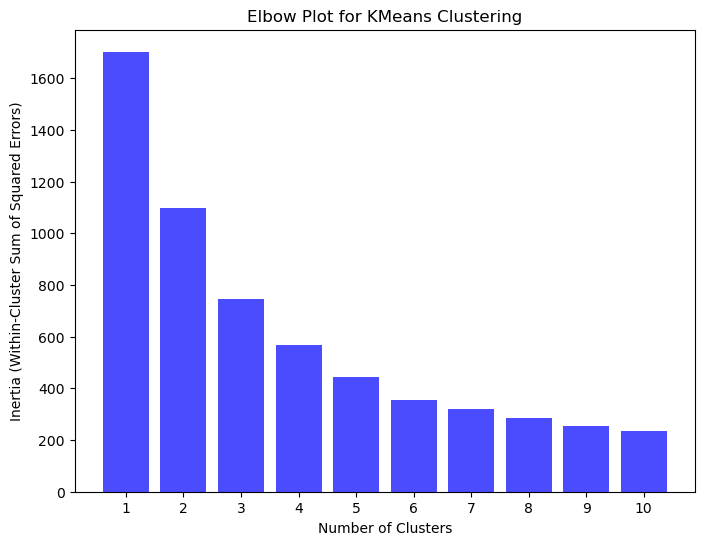

In [13]:
#the elbow method should help you to determine the number of clusters fo the kmeans clustering
mo.kmeans_elbow_plot(scores,
                     output_folder=output_folder,
                     output_format = output_format,
                     savefig = True,
                     max_clusters=10)

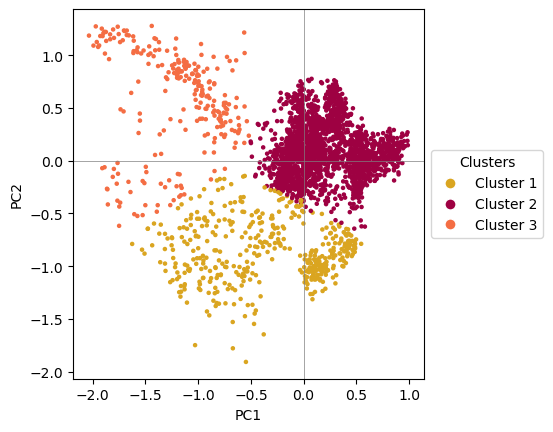

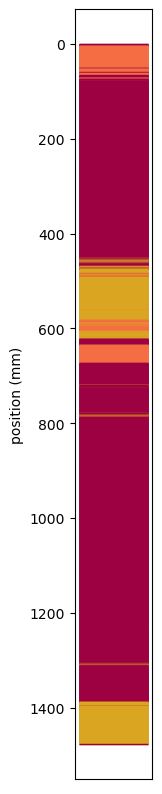

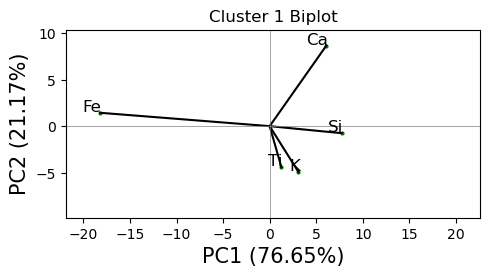

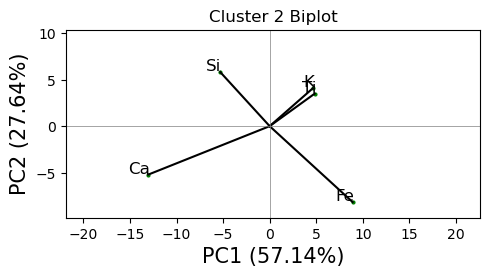

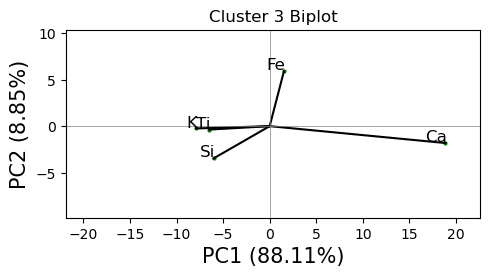

,cluster
position (mm),
0.0,1
0.5,1
1.0,1
1.5,1
2.0,1
...,...
1475.0,0
1475.5,0
1476.0,0


In [14]:
#kmeans clustering
mo.kmeans_clustering(scores, 
                    elements_clr, 
                    n_clusters, 
                    colors, 
                    output_folder = output_folder, 
                    output_format = output_format,
                    savefig=True, #Do you want the save the plots and cluster dataframe?
                    linewidth = linewidth)
